In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation=doc['annotation']


In [2]:
tss_annotation = doc['tss_annotation']

In [3]:

import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
### notebook specific configuration ###
from os.path import basename
#mpl.style.use('ggplot')
mpl.style.use('fivethirtyeight')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from Modules.Homer import *

print('Number of tissues: ',len(tissues))

('Number of tissues: ', 16)


In [4]:
sys.path.append('/home/isshamie/software/parallel_helper')
import parallel_functions as pf

In [5]:
## Bio import
from Bio import motifs as mt
from Bio.Seq import Seq
from Bio import SeqIO

In [6]:
motifs_folder = 'supplemental/homer_motifs/'
motifs_of_interest = ['tata','sp1','ctcf','inr']

## Load in motif results

In [7]:
anno_peaks = pd.read_csv("Results/peaks_with_tss_and_gene.tsv",sep='\t',index_col=0)
anno_peaks['Length'] = anno_peaks['End'] - anno_peaks['Start']
anno_peaks.head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Distance to TSS,Nearest PromoterID,Nearest TSS,isSameStrand,Nearest gene,Nearest gene_id,Length
PeakID (cmd=annotatePeaks.pl Results/merged/all_peaks_merged.tsv /data/isshamie/genome/picr.fa -gff /data/isshamie/genome/updated_final_sort.gff3),,,,,,,,,,,,,,
Merged-picr_48-1084706-14,picr_48,1084630,1084782,+,50717.441406,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,TTS (ID=asmbl_56918.exon2;Parent=asmbl_56918;g...,127017.0,ID=asmbl_56919.exon2;Parent=asmbl_56919;gene_i...,asmbl_56916,True,MTHFD1L,gene_20259_1,152
Merged-picr_33-4827737-11,picr_33,4827637,4827815,+,17077.398438,/data/isshamie/TSS/Processed/Brain/mSTART/f04_...,promoter-TSS (ID=asmbl_45526.exon1;Parent=asmb...,4.0,ID=asmbl_45526.exon1;Parent=asmbl_45526;gene_i...,asmbl_45526,True,CPA2,gene_16120,178
Merged-picr_13-30535388-7,picr_13,30535313,30535463,+,15631.878906,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,promoter-TSS (ID=asmbl_16617.exon1;Parent=asmb...,-267.0,ID=asmbl_16613.exon1;Parent=asmbl_16613;gene_i...,asmbl_16611,False,PARP16,gene_5744,150
Merged-picr_64-11363665-15,picr_64,11363590,11363741,+,8920.436523,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,Intergenic,-42355.0,ID=asmbl_69800.exon2;Parent=asmbl_69800;gene_i...,asmbl_69802,True,GRM3,gene_24621,151
Merged-picr_16-22007181-6,picr_16,22007101,22007263,+,6541.673828,/data/isshamie/TSS/Processed/Brain/mSTART/f04_...,promoter-TSS (ID=asmbl_24868.exon3;Parent=asmb...,-25868.0,ID=asmbl_24866.exon2;Parent=asmbl_24866;gene_i...,asmbl_24876,True,DSCAML1,gene_8431,162


## Create an n-by-m matrix where |n|= Number of peaks and |m| = Number of motifs and each element is a count for how many times that motif was seen within +/- 75 bp of peak


In [8]:
all_motifs = glob.glob('Results/motifs/all_peaks_merged_anno*instance.p')

In [10]:
def motif_counts(seq_len,motif_instances,bins=[-75,75],compl_strand=False):
    ### Returns counts of motifs within the a certain range. 
    ### If compl_strand=True, it returns a tuple with number of positive hits as the first element 
    ### And negative elements as the second.
    mid = np.ceil(seq_len/2)
    curr_motif_instance = np.array(motif_instances) #From list to array
    
    if compl_strand:
        pos = curr_motif_instance[np.apply_along_axis(lambda x: x>=0,0,curr_motif_instance)]
        neg = curr_motif_instance[np.apply_along_axis(lambda x: x<0,0,curr_motif_instance)]
        pos_count = np.sum(np.apply_along_axis(lambda x: (bins[0] < mid - x) & (mid-x < bins[1]),0,pos))
        neg = np.abs(neg)
        neg_count = np.sum(np.apply_along_axis(lambda x: (bins[0] < mid - x) & (mid-x < bins[1]),0,neg))
        return (pos_count,neg_count)
        #return list(map(lambda x: bins[0] < mid - x and mid-x < bins[1] ,motif_instances)).count(True) 
    else:
        return np.sum(np.apply_along_axis(lambda x: (bins[0] < mid - x) & (mid-x < bins[1]),0,curr_motif_instance))

In [11]:
def wrap_motifs(df,anno_df,motifs,new_col):
    not_in_peaks = 0
    for peak, val in df.iterrows():
        seq_len = anno_df.loc[peak,'Length']
        if peak in motifs:
            motif_instances = motifs[peak]
            #motif_instances = df.loc[peak,'instances']
            df.at[peak,new_col] = motif_counts(seq_len,motif_instances,compl_strand=True)[0]
        else:
            df.at[peak,new_col] = 0
            not_in_peaks += 1
    #print('Not found in peaks', not_in_peaks)
    return df

In [16]:
%%time
all_motifs = glob.glob('Results/motifs/all_peaks_merged_anno*instance.p')
all_motifs = list(filter(lambda x:'inr' in x or 'tata' in x,all_motifs))
motif_names = map(lambda x: os.path.basename(x).split('_')[-2],all_motifs)

peak_motif_counts = pd.DataFrame(index=anno_peaks.index,columns = motif_names)
#peak_motif_counts = pd.DataFrame(index=anno_peaks.index)

for ind,i in enumerate(all_motifs):
    print(ind)
    print(i)
    f_out = i
    motifs = pickle.load(open(f_out,'rb'))

    print(motif_names[ind])
    #peak_motif_counts = wrap_motifs(anno_peaks,motifs,motif_names[ind])
    peak_motif_counts = pf.parallel_df(peak_motif_counts,func=wrap_motifs,func_args=[anno_peaks[['Length']],motifs,motif_names[ind]],num_processes=2)

0
Results/motifs/all_peaks_merged_anno_inr_instance.p
inr
1
Results/motifs/all_peaks_merged_anno_tata_instance.p
tata
CPU times: user 37.2 s, sys: 3.14 s, total: 40.3 s
Wall time: 4min 55s


In [17]:
peak_motif_counts.head()

,inr,tata
PeakID (cmd=annotatePeaks.pl Results/merged/all_peaks_merged.tsv /data/isshamie/genome/picr.fa -gff /data/isshamie/genome/updated_final_sort.gff3),,
Merged-picr_48-1084706-14,0,0
Merged-picr_33-4827737-11,0,4
Merged-picr_13-30535388-7,0,2
Merged-picr_64-11363665-15,0,5
Merged-picr_16-22007181-6,0,2


In [18]:
peak_motif_counts.to_csv('Results/motifs/all_peaks_instances_combined.csv')

In [8]:
peak_motif_counts = pd.read_csv('Results/motifs/all_peaks_instances_combined.csv',index_col=0)

In [9]:
peak_motif_counts.head()

,inr,tata
PeakID (cmd=annotatePeaks.pl Results/merged/all_peaks_merged.tsv /data/isshamie/genome/picr.fa -gff /data/isshamie/genome/updated_final_sort.gff3),,
Merged-picr_48-1084706-14,0,0
Merged-picr_33-4827737-11,0,4
Merged-picr_13-30535388-7,0,2
Merged-picr_64-11363665-15,0,5
Merged-picr_16-22007181-6,0,2


------------

------------

------------

## Clustering

In [20]:
np.array(peak_motif_counts)

array([[0, 0],
       [0, 4],
       [0, 2],
       ..., 
       [0, 0],
       [0, 3],
       [1, 2]], dtype=object)

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage


In [ ]:
X = np.array(peak_motif_counts)

In [ ]:
Z = linkage(X, 'ward')

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

In [ ]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

-----------------

-----------------

-----------------

34253


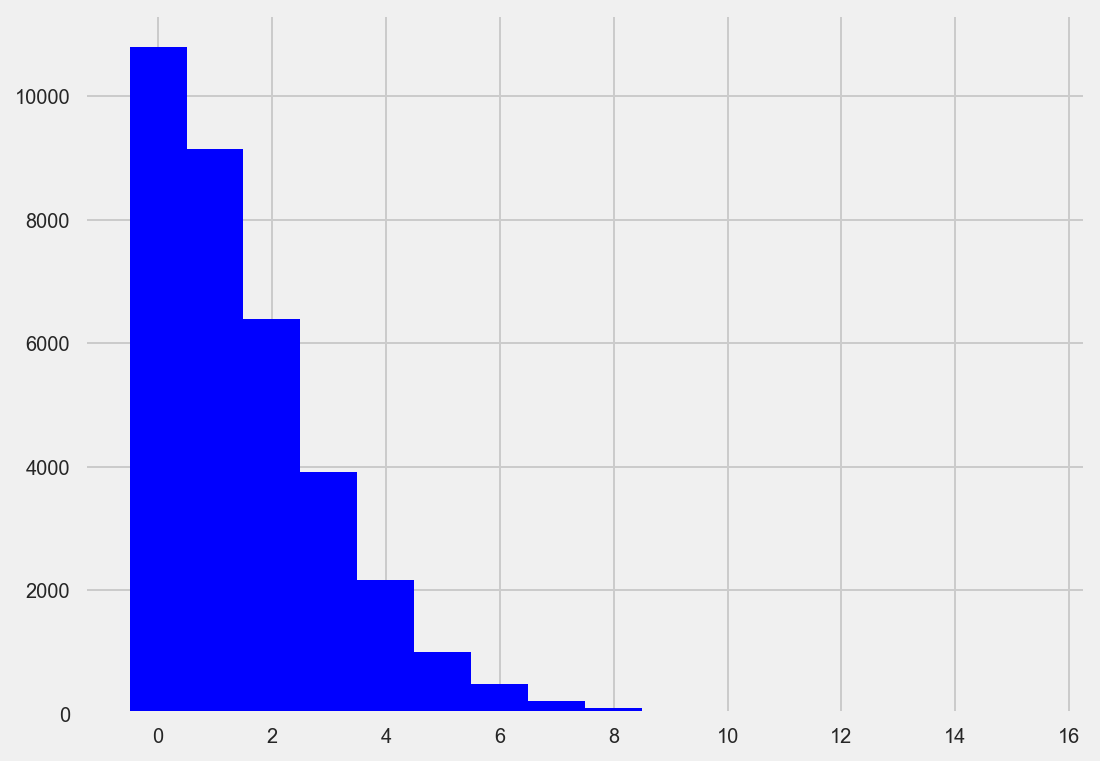

In [10]:

lens = []
for key in motifs:
    curr = np.array(motifs[key])
    hits = np.sum(curr>0)
    #lens.append(len(motifs[key]))
    lens.append(hits)


from collections import Counter

labels, values = zip(*Counter(lens).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
#plt.xticks(indexes + width * 0.5, labels)
plt.show()
